<h1><center> Visualisation of the dataset

In [1]:
# Import the libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime as dt
import networkx as nx
from tqdm import tqdm
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.concat([pd.read_csv('../data/atlantic.csv'), pd.read_csv('../data/pacific.csv')]).reset_index(drop=True)
# Convert date column as datetime.
df['Date'] = pd.to_datetime(df['Date'] , format= '%Y%m%d')

In [3]:
# I want to create columns Latitude Hemisphere and Longitude Hemisphere with code 0 = N , 1 = S & 0 = E , 1 = W.
def hemisphere(coord):
        hem = re.findall(r'[NSWE]' , coord)[0]
        if hem == 'N' or hem == 'E':
            return 0
        else:
            return 1

def convert_lat_long_to_vaulue(n):
    value = float(n[:-1])
    if n[-1] == "N":
        return value
    else:
        return - value

# Creating the column Latitude_Hemisphere.
df['Latitude_Hemisphere'] = df['Latitude'].apply(hemisphere)
df['Longitude_Hemisphere'] = df['Longitude'].apply(hemisphere)
df['Latitude_Hemisphere'] = df['Latitude_Hemisphere'].astype('category')
df['Longitude_Hemisphere'] = df['Longitude_Hemisphere'].astype('category')

# Convert the latitude and longitude Column to numeric type.
df['Latitude'] =  df['Latitude'].apply(lambda x: re.match('[0-9]{1,3}.[0-9]{0,1}' , x)[0])
df['Longitude'] =   df['Longitude'].apply(lambda x: re.match('[0-9]{1,3}.[0-9]{0,1}' , x)[0])
# df['Latitude'] =  df['Latitude'].apply(convert_lat_long_to_vaulue)
# df['Longitude'] =   df['Longitude'].apply(convert_lat_long_to_vaulue)

# The missing values are given by -999. So , we need to fill them appropriately.

# Show the count of missing values and fill them with mean.
for column in df.columns:
    missing_cnt = df[column][df[column] == -999].count()
    print('Missing Values in column {col} = '.format(col = column) , missing_cnt )
    if missing_cnt!= 0:
#         print('in ' , column)
        mean = round(df[column][df[column] != -999 ].mean())
#         print("mean",mean)
        index = df.loc[df[column] == -999 , column].index
#         print("index" , index )
        df.loc[df[column] == -999 , column] = mean
#         print(df.loc[index , column])

# Restructure the dataframe for visibility and remove columns ID and Event.
df =  df[['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude', 'Latitude_Hemisphere' ,
       'Longitude', 'Longitude_Hemisphere' ,'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']]

# Change all time to format HHMM.
df['Time'] = df['Time'].astype('object')
def hhmm(time):
    time = str(time)
    digits = re.findall(r'\d', time)
    t = ''
    if len(digits) == 1:
        t ='0{i}00'.format(i =time)
    elif len(digits) == 2:
        t = '00{i}'.format(i =time)
    elif len(digits) == 3:
        t = '0{i}'.format(i =time)
    else:
        t = time
    return t

# Apply the function.
df['Time'] = df['Time'].apply(hhmm)

# Convert the column into Datetime.
df['Time'] = pd.to_datetime(df['Time'] , format='%H%M').dt.time


# Convert the status column to categorical.
df['Status'] = df['Status'].astype('category')

data = df.drop(columns = ['ID' , 'Event'])

Missing Values in column ID =  0
Missing Values in column Name =  0
Missing Values in column Date =  0
Missing Values in column Time =  0
Missing Values in column Event =  0
Missing Values in column Status =  0
Missing Values in column Latitude =  0
Missing Values in column Longitude =  0
Missing Values in column Maximum Wind =  0
Missing Values in column Minimum Pressure =  43473
Missing Values in column Low Wind NE =  62934
Missing Values in column Low Wind SE =  62934
Missing Values in column Low Wind SW =  62934
Missing Values in column Low Wind NW =  62934
Missing Values in column Moderate Wind NE =  62934
Missing Values in column Moderate Wind SE =  62934
Missing Values in column Moderate Wind SW =  62934
Missing Values in column Moderate Wind NW =  62934
Missing Values in column High Wind NE =  62934
Missing Values in column High Wind SE =  62934
Missing Values in column High Wind SW =  62934
Missing Values in column High Wind NW =  62934
Missing Values in column Latitude_Hemisp

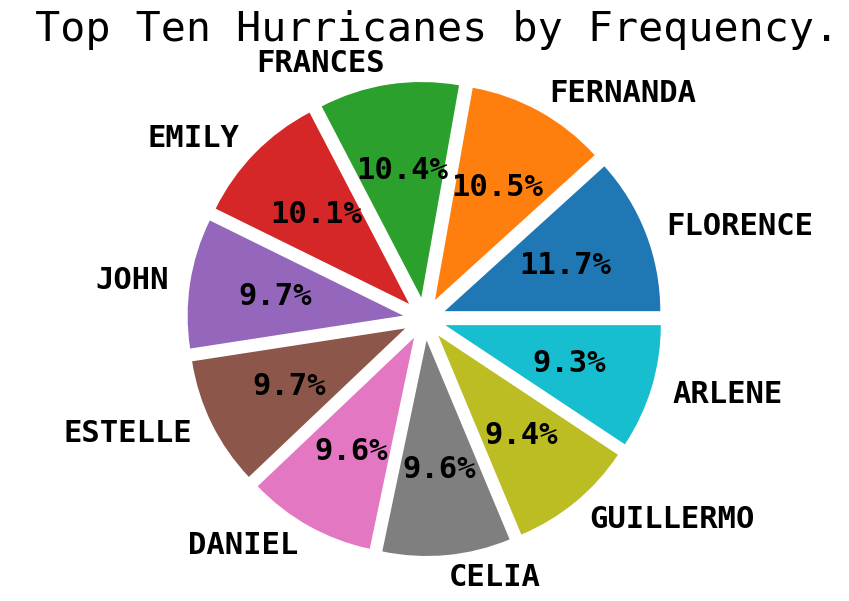

In [4]:
# Find the top ten cyclones which have occured the maximum number of times.
lst = [x.strip() for x in data[data["Name"] != "            UNNAMED"].groupby('Name').count().sort_values(by = 'Date' , ascending = False).index[:10]]
val = data[data["Name"] != "            UNNAMED"].groupby('Name').count().sort_values(by = 'Date' , ascending = False)[:10]['Date'].values
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
fig , ax = plt.subplots()
fig.set_size_inches(7,7)
ax.pie(  labels = lst , x = val , autopct='%.1f%%' , explode = [0.1 for x in range(10)])
plt.title(' Top Ten Hurricanes by Frequency.' , fontsize = 30)
plt.show()

C:\Users\theog\AppData\Local\Temp\ipykernel_19672\3337764282.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = temp.index , y = 'Date' , data=temp , palette = 'RdBu' )


Text(0.5, 1.0, 'Frequency of Cyclones by Month.')

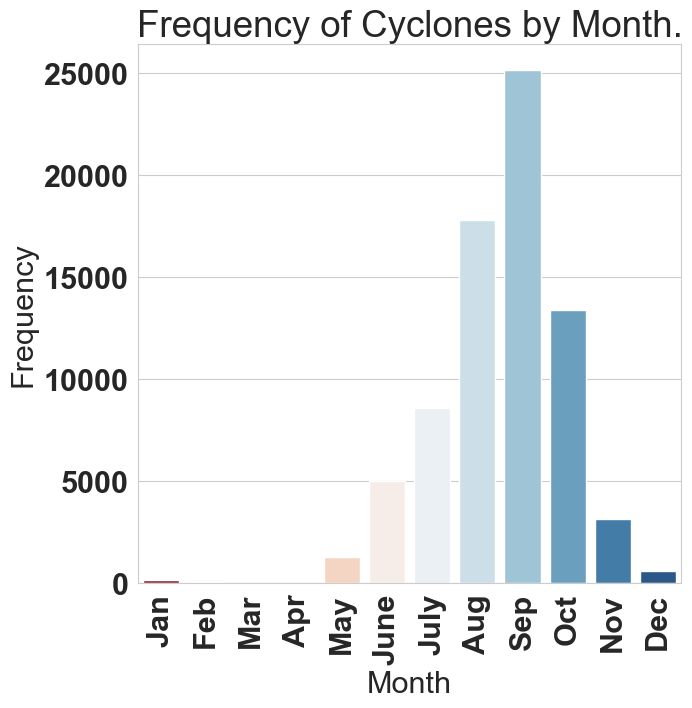

In [5]:
data['Month'] = data['Date'].apply(lambda x: x.month)
data['Year'] = data['Date'].apply(lambda x: x.year)
mnt = ['Jan' , 'Feb' , 'Mar' , 'Apr' , 'May' , 'June' , 'July' , 'Aug' , 'Sep','Oct' , 'Nov' , 'Dec']
temp = data.groupby('Month').count()
temp.loc[4] = 0
temp = temp.sort_values(by = 'Month' , ascending = False)
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.figure(figsize = (7,7))
sns.set_style("whitegrid")
ax = sns.barplot(x = temp.index , y = 'Date' , data=temp , palette = 'RdBu' )
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11] , mnt , rotation = 90)
plt.ylabel('Frequency')
plt.title('Frequency of Cyclones by Month.')

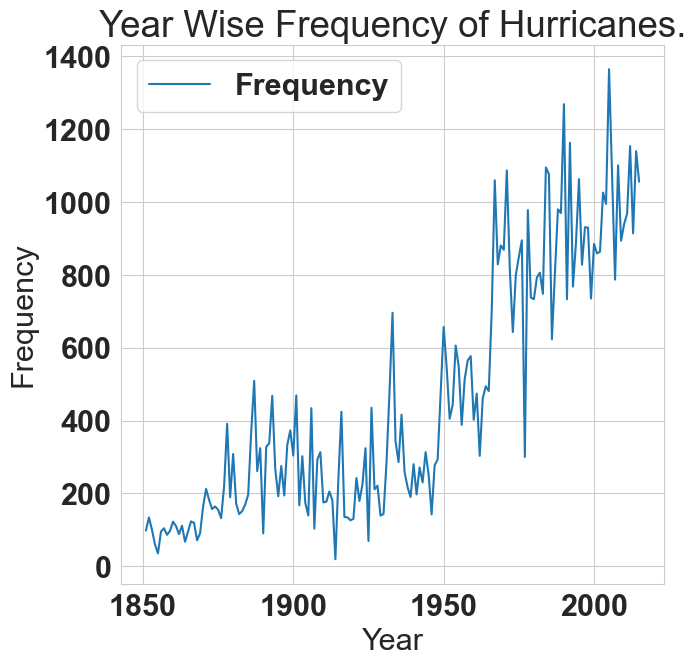

In [6]:
# Year-Wise Frequency of Hurricanes.
temp = data.groupby('Year').count().sort_values(by = 'Month' , ascending = False)
plt.figure(figsize= (7,7))
sns.lineplot(x = temp.index , y = 'Month' , data = temp , label = 'Frequency')
plt.ylabel('Frequency')
plt.title('Year Wise Frequency of Hurricanes.')
plt.show()

C:\Users\theog\AppData\Local\Temp\ipykernel_19672\2968359424.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp['Date'].values , norm_hist = True , axlabel = 'Probability Distribution of Frequency of Cyclones.')


<AxesSubplot:xlabel='Probability Distribution of Frequency of Cyclones.', ylabel='Density'>

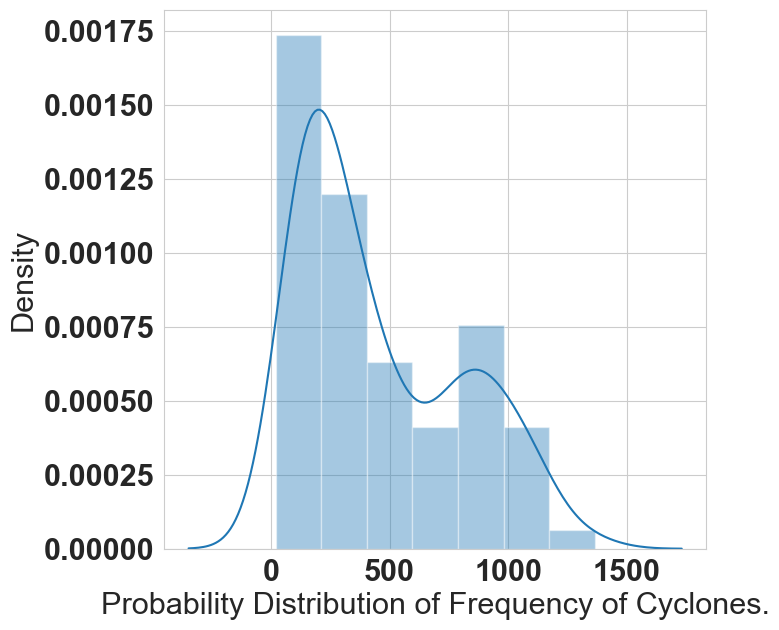

In [7]:
# Probability Distribution Function of Frequency.
temp = data.groupby('Year').count().sort_values(by = 'Date' , ascending = False)
plt.figure(figsize=(7,7))
sns.distplot(temp['Date'].values , norm_hist = True , axlabel = 'Probability Distribution of Frequency of Cyclones.')

C:\Users\theog\AppData\Local\Temp\ipykernel_19672\2294314944.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = data.groupby('Status').count().sort_values(by = 'Date' , ascending = False)
C:\Users\theog\AppData\Local\Temp\ipykernel_19672\2294314944.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = list(temp.index) , x = 'Date' , data = temp, palette= 'pastel' )


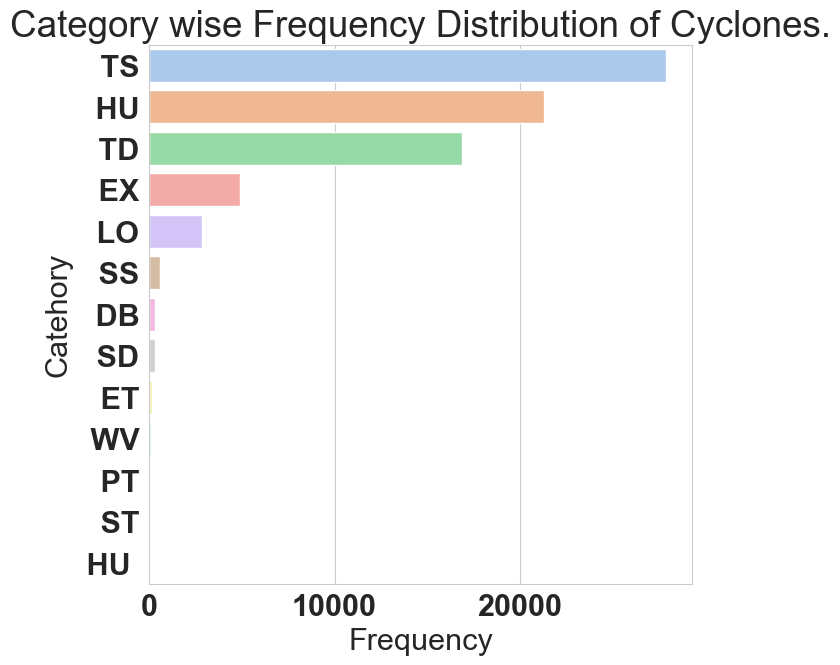

In [8]:
## Frequency of Cyclones by Category
# TD – Tropical cyclone of tropical depression intensity (< 34 knots)
# TS – Tropical cyclone of tropical storm intensity (34-63 knots)
# HU – Tropical cyclone of hurricane intensity (> 64 knots)
# EX – Extratropical cyclone (of any intensity)
# SD – Subtropical cyclone of subtropical depression intensity (< 34 knots)
# SS – Subtropical cyclone of subtropical storm intensity (> 34 knots)
# LO – A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)
# WV – Tropical Wave (of any intensity)
# DB – Disturbance (of any intensity)
temp = data.groupby('Status').count().sort_values(by = 'Date' , ascending = False)
fig , ax = plt.subplots()
fig.set_size_inches(7,7)
sns.barplot(y = list(temp.index) , x = 'Date' , data = temp, palette= 'pastel' )
plt.xlabel('Frequency')
plt.ylabel('Catehory')
plt.title('Category wise Frequency Distribution of Cyclones.')
plt.show()

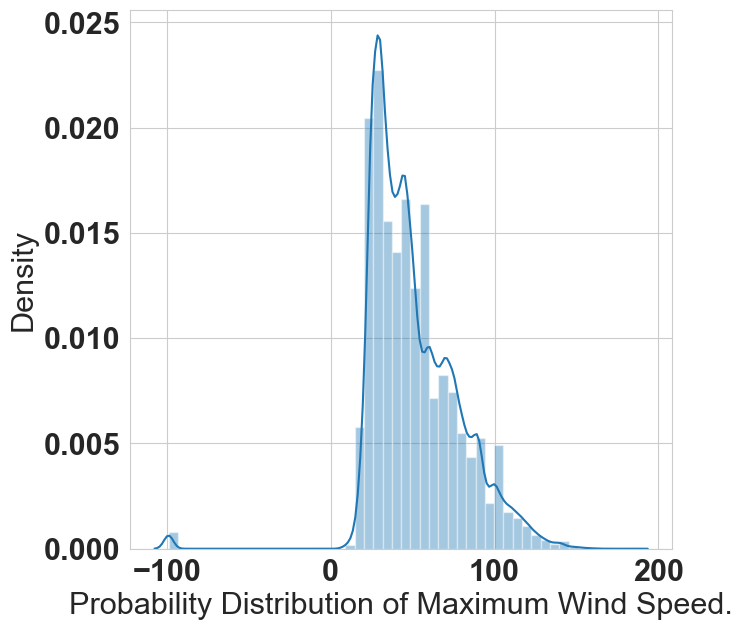

In [18]:
# Show distribution of maximum wind.

plt.figure(figsize=(7,7))
sns.distplot(df['Maximum Wind'] , axlabel = 'Probability Distribution of Maximum Wind Speed.')
plt.show()